# Supercharge Training of your Deep Learning Models
> The Power of One-Cycle Learning Rate

Learn how **One-Cycle Learning Rate** can help you train your deep learning models faster and more efficiently. This notebook showcases the performance improvement for **MobileNetV2** on a fun dataset of **rock-paper-scissors**

More details in the Medium Article

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExbG1henJ5dzRnMHpkb3RycThvb240Z2ptYXN2OGlkbmZ6aXBhZDM1eiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/J54y1LH5rBQw2Zziqa/giphy.gif">

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random
import pandas as pd
import seaborn as sns

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

Python version: 3.10.12
Tensorflow version: 2.14.0


In [3]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteKJUHGE/rock_paper_scissors-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteKJUHGE/rock_paper_scissors-test.tfrecord*...:   0%|         …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [4]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

In [5]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# Set the Input Image size as per the model parameters
INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 128
Input image shape (reduced): (128, 128, 3)


Input image size: 128
Input image shape: (128, 128, 3)


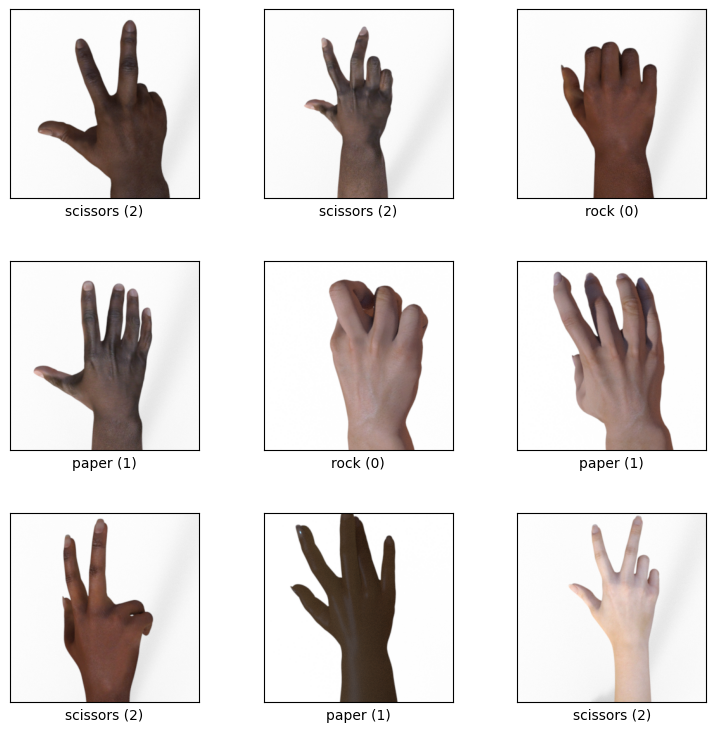

In [6]:
fig = tfds.show_examples(dataset_train_raw, dataset_info)

In [7]:
def normalise_dataset(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.

    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [8]:
dataset_train = dataset_train_raw.map(normalise_dataset)
dataset_test = dataset_test_raw.map(normalise_dataset)

In [9]:
def data_augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
def data_augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def data_augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
def data_augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image
def data_augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop ratios
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # generate crops
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # randomly apply crops less than 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [10]:
def augment_data(image, label):
    image = data_augment_flip(image)
    image = data_augment_color(image)
    image = data_augment_rotation(image)
    image = data_augment_zoom(image)
    image = data_augment_inversion(image)
    return image, label

In [11]:
dataset_train_augmented = dataset_train.map(augment_data)

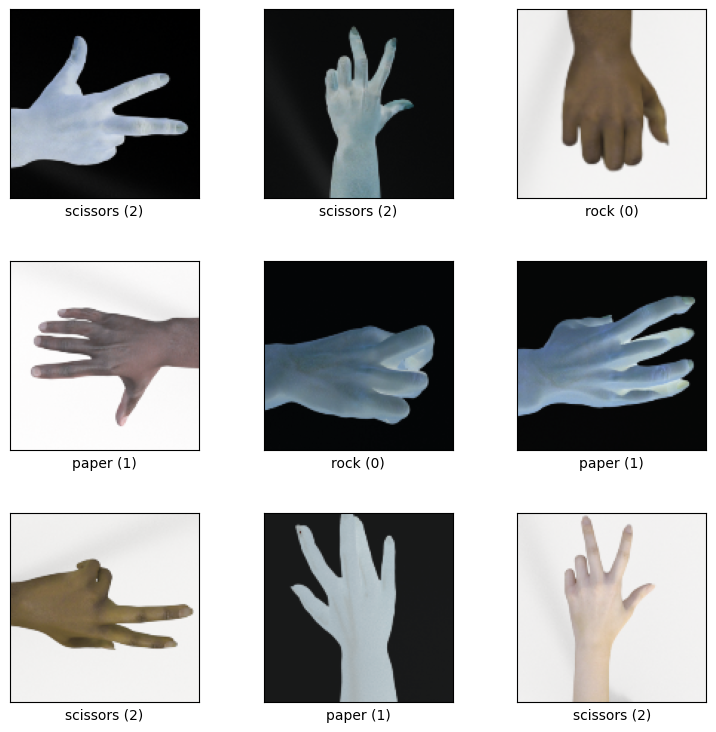

In [12]:
fig = tfds.show_examples(dataset_train_augmented, dataset_info)

In [13]:
BATCH_SIZE = 64

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)
dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [14]:
def plot_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='training set')
    plt.plot(val_loss, label='validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='training set')
    plt.plot(val_accuracy, label='validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

In [15]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 39
validation_steps: 5


In [17]:
initial_epochs = 20

## Simple CNN

In [18]:
simple_model = tf.keras.models.Sequential()

simple_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=1,
                  padding='same', activation='relu'))
simple_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
simple_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=1,
                  padding='same', activation='relu'))
simple_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
simple_model.add(tf.keras.layers.Flatten())
simple_model.add(tf.keras.layers.Dense(64, activation='relu'))
simple_model.add(tf.keras.layers.Dropout(rate=0.3))
simple_model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))

In [19]:
simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [20]:
simple_training_history = simple_model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
39/39 [==============================] - 29s 404ms/step - loss: 1.1830 - accuracy: 0.4115 - val_loss: 1.1418 - val_accuracy: 0.3500
Epoch 2/20
39/39 [==============================] - 11s 266ms/step - loss: 0.8603 - accuracy: 0.6515 - val_loss: 1.1030 - val_accuracy: 0.3969
Epoch 3/20
39/39 [==============================] - 11s 298ms/step - loss: 0.6377 - accuracy: 0.7480 - val_loss: 1.1430 - val_accuracy: 0.4187
Epoch 4/20
39/39 [==============================] - 12s 310ms/step - loss: 0.4990 - accuracy: 0.8225 - val_loss: 0.8613 - val_accuracy: 0.5844
Epoch 5/20
39/39 [==============================] - 11s 298ms/step - loss: 0.4100 - accuracy: 0.8721 - val_loss: 0.7692 - val_accuracy: 0.6250
Epoch 6/20
39/39 [==============================] - 14s 366ms/step - loss: 0.3312 - accuracy: 0.8994 - val_loss: 0.7878 - val_accuracy: 0.5969
Epoch 7/20
39/39 [==============================] - 12s 303ms/step - loss: 0.3209 - accuracy: 0.9002 - val_loss: 0.7022 - val_accuracy: 0.7063

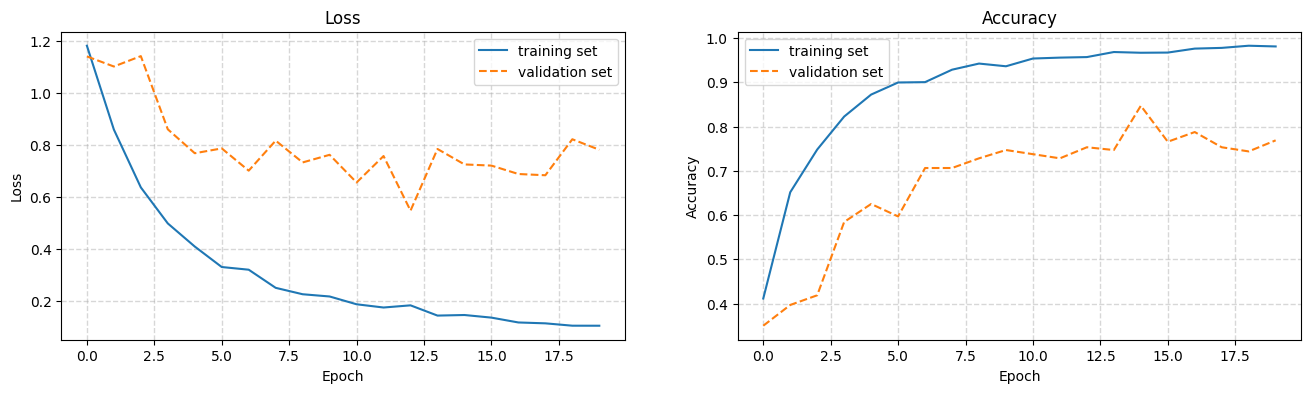

In [21]:
plot_training_history(simple_training_history)

In [22]:
train_loss, train_accuracy = simple_model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)
test_loss, test_accuracy = simple_model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

6/6 [==============================] - 1s 134ms/step - loss: 0.7587 - accuracy: 0.7796


In [23]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.05251571908593178
Training accuracy:  0.9976190328598022


Test loss:  0.7586842179298401
Test accuracy:  0.7795698642730713


## Transfer Learning with MobileNetV2

In [24]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
base_model.trainable = False

In [26]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [28]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
39/39 [==============================] - 15s 299ms/step - loss: 1.1266 - accuracy: 0.5541 - val_loss: 1.0212 - val_accuracy: 0.6000
Epoch 2/20
39/39 [==============================] - 11s 274ms/step - loss: 0.5050 - accuracy: 0.8200 - val_loss: 0.5782 - val_accuracy: 0.7250
Epoch 3/20
39/39 [==============================] - 11s 296ms/step - loss: 0.3781 - accuracy: 0.8762 - val_loss: 0.4133 - val_accuracy: 0.8406
Epoch 4/20
39/39 [==============================] - 10s 274ms/step - loss: 0.3023 - accuracy: 0.9072 - val_loss: 0.3427 - val_accuracy: 0.8687
Epoch 5/20
39/39 [==============================] - 11s 279ms/step - loss: 0.2635 - accuracy: 0.9255 - val_loss: 0.3179 - val_accuracy: 0.8750
Epoch 6/20
39/39 [==============================] - 11s 288ms/step - loss: 0.2423 - accuracy: 0.9381 - val_loss: 0.3105 - val_accuracy: 0.8906
Epoch 7/20
39/39 [==============================] - 11s 295ms/step - loss: 0.2134 - accuracy: 0.9495 - val_loss: 0.2733 - val_accuracy: 0.9062

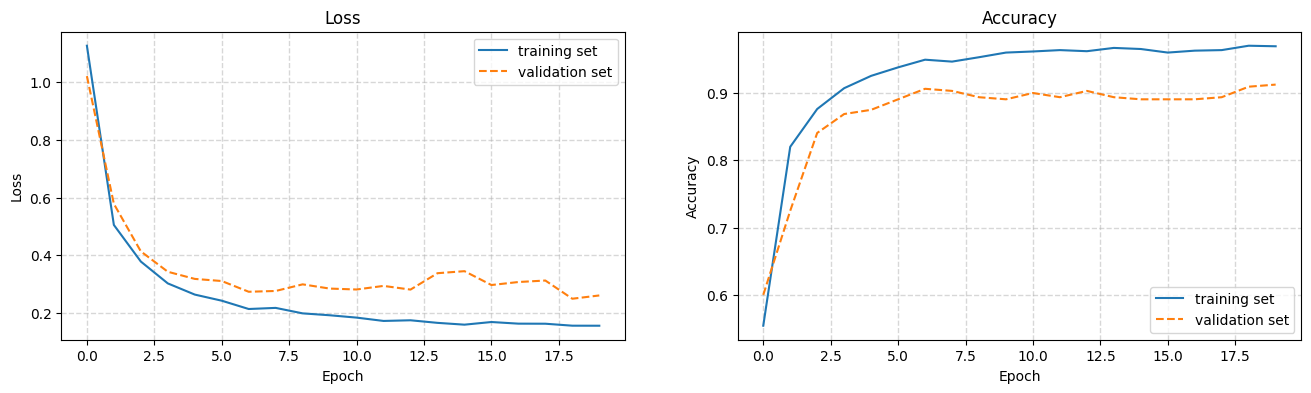

In [29]:
plot_training_history(training_history)

In [30]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)
test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

6/6 [==============================] - 1s 103ms/step - loss: 0.2453 - accuracy: 0.9220


In [31]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.0918056070804596
Training accuracy:  0.9960317611694336


Test loss:  0.24527719616889954
Test accuracy:  0.9220430254936218


## Super Convergence : Transfer Learning with MobileNetV2  
> 1-Cycle Rate

In [32]:
def lr_function(epoch):
    start_lr = 1e-3; min_lr = 1e-3; max_lr = 2e-3
    rampup_epochs = 6; sustain_epochs = 0; exp_decay = .5

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr,
              rampup_epochs, sustain_epochs, exp_decay)

start lr: 0.001 
end lr: 0.0010001220703125


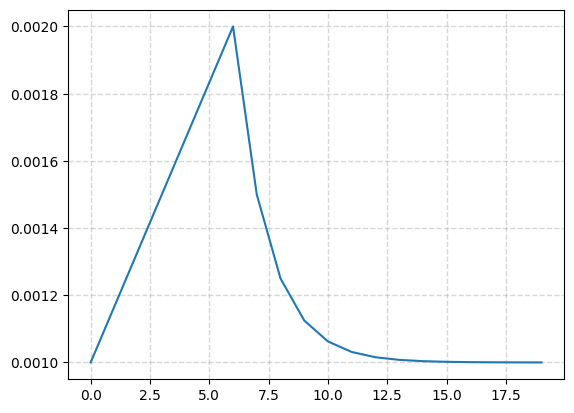

In [33]:
rng = [i for i in range(initial_epochs)]
y = [lr_function(x) for x in rng]
plt.plot(rng, [lr_function(x) for x in rng])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
print('start lr:', y[0], '\nend lr:', y[-1])

In [34]:
model_lr = tf.keras.models.Sequential()

model_lr.add(base_model)

model_lr.add(tf.keras.layers.Dropout(0.5))

model_lr.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

model_lr.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [36]:
training_history_lr = model_lr.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lambda epoch: \
                                             lr_function(epoch),
                                             verbose=True)
    ],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
39/39 [==============================] - 15s 328ms/step - loss: 1.1518 - accuracy: 0.5381 - val_loss: 0.6150 - val_accuracy: 0.7875 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0011666666666666668.
Epoch 2/20
39/39 [==============================] - 11s 281ms/step - loss: 0.5212 - accuracy: 0.8221 - val_loss: 0.5598 - val_accuracy: 0.7625 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.0013333333333333333.
Epoch 3/20
39/39 [==============================] - 15s 378ms/step - loss: 0.3434 - accuracy: 0.8929 - val_loss: 0.3486 - val_accuracy: 0.9125 - lr: 0.0013

Epoch 4: LearningRateScheduler setting learning rate to 0.0015.
Epoch 4/20
39/39 [==============================] - 16s 412ms/step - loss: 0.2733 - accuracy: 0.9235 - val_loss: 0.2608 - val_accuracy: 0.9438 - lr: 0.0015

Epoch 5: LearningRateScheduler setting learning rate to 0.0016666666666666666.
Epoch 5

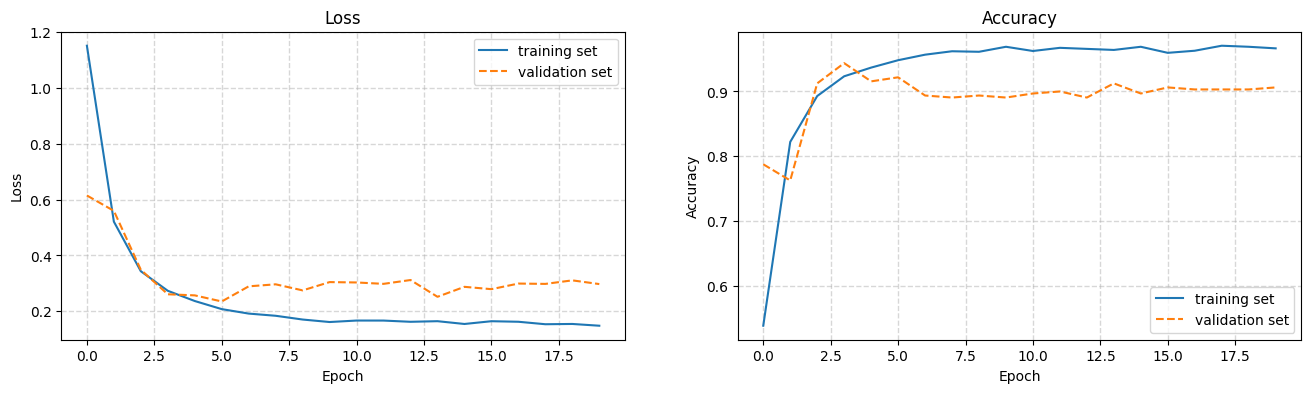

In [37]:
plot_training_history(training_history_lr)

In [38]:
train_loss, train_accuracy = model_lr.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model_lr.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

6/6 [==============================] - 0s 31ms/step - loss: 0.2786 - accuracy: 0.9167


In [39]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.09348942339420319
Training accuracy:  0.9940476417541504


Test loss:  0.27864792943000793
Test accuracy:  0.9166666865348816


## Compare Performance of the Three Models

In [40]:
history_df1 = pd.DataFrame(simple_training_history.history)
history_df1['model'] = 'simple_cnn'

history_df2 = pd.DataFrame(training_history.history)#.head(50)
history_df2['model'] = 'mobileNetV2'

history_df3 = pd.DataFrame(training_history_lr.history)#.head(50)
history_df3['model'] = 'mobileNetV2_lr'

history_df = pd.concat([history_df1,history_df2,history_df3])#,
history_df.shape

(60, 6)

In [41]:
history_df.reset_index(inplace=True,)
history_df.rename(columns={'index':'epoch'},inplace=True)

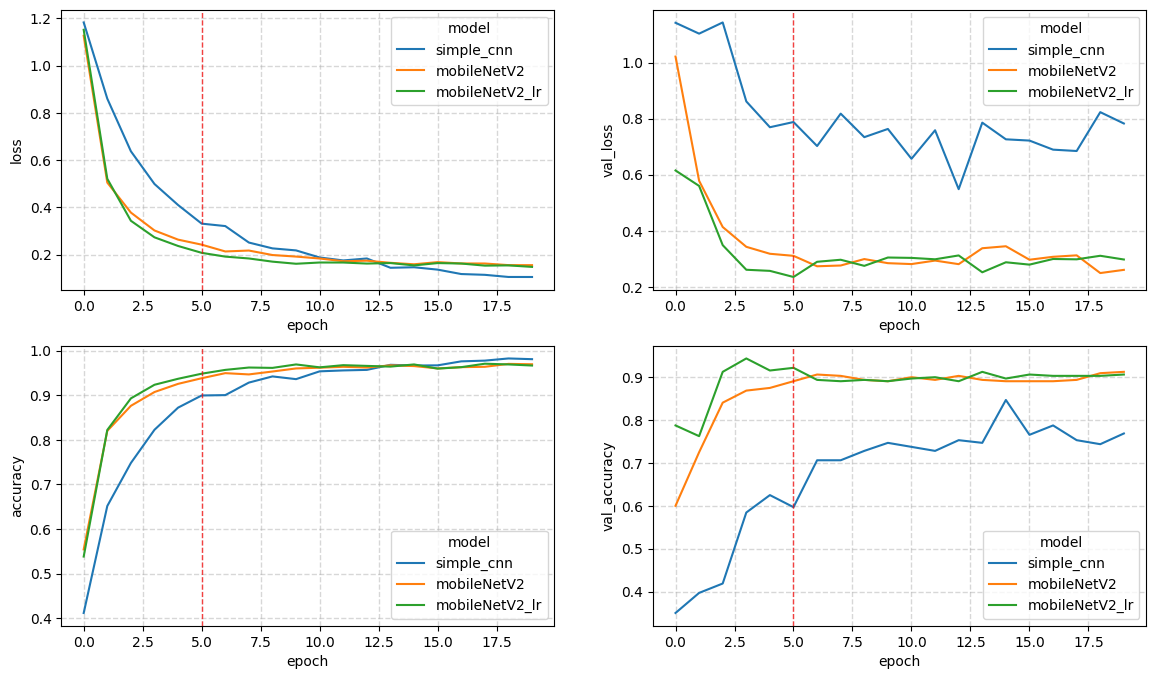

In [42]:
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x='epoch',y='loss',hue='model',data=history_df)
plt.axvline(x=5,c='r',linestyle='--', linewidth=1, alpha=0.7)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(2, 2, 2)
sns.lineplot(x='epoch',y='val_loss',hue='model',data=history_df)
plt.axvline(x=5,c='r',linestyle='--', linewidth=1, alpha=0.7)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(2, 2, 3)
sns.lineplot(x='epoch',y='accuracy',hue='model',data=history_df)
plt.axvline(x=5,c='r',linestyle='--', linewidth=1, alpha=0.7)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(2, 2, 4)
sns.lineplot(x='epoch',y='val_accuracy',hue='model',data=history_df)
plt.axvline(x=5,c='r',linestyle='--', linewidth=1, alpha=0.7)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)